# Word Embeddings + various classification algorithms

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
import gensim
from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer

import time
import csv
from tqdm import tqdm
from bs4 import BeautifulSoup
import re, string
import nltk
from nltk.corpus import stopwords
import pickle
from tabulate import tabulate

import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2023-05-21 20:04:25.298653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('../../data/liar_dataset/train.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])
test = pd.read_csv('../../data/liar_dataset/test.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])
valid = pd.read_csv('../../data/liar_dataset/valid.tsv', sep="\t", usecols=[1, 2], names = ["label", "text"])

train = pd.concat([train, valid])

In [3]:
train['label'].value_counts()

half-true      2362
false          2258
mostly-true    2213
barely-true    1891
true           1845
pants-fire      955
Name: label, dtype: int64

In [4]:
convert_text_labels = lambda x: 0 if x in ['true', 'mostly-true'] else 1

In [5]:
train['label'] = train['label'].apply(convert_text_labels)
test['label'] = test['label'].apply(convert_text_labels)

In [6]:
train['label'].value_counts()

1    7466
0    4058
Name: label, dtype: int64

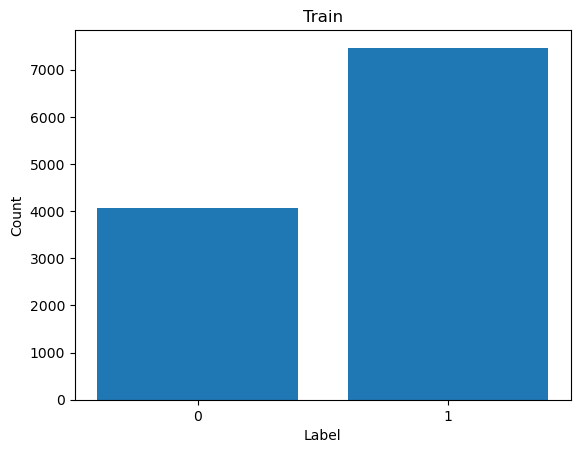

In [7]:
plt.bar(train['label'].value_counts().index, train['label'].value_counts().values)

plt.xticks(train['label'].value_counts().index)

plt.title('Train')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [8]:
test['label'].value_counts()

1    818
0    449
Name: label, dtype: int64

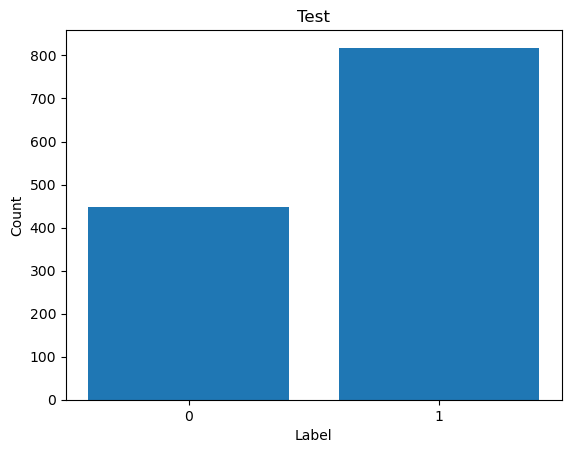

In [9]:
plt.bar(test['label'].value_counts().index, test['label'].value_counts().values)

plt.xticks(test['label'].value_counts().index)

plt.title('Test')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [10]:
train['text'].str.len().describe()

count    11524.000000
mean       106.895783
std         58.415051
min         11.000000
25%         73.000000
50%         99.000000
75%        133.000000
max       3192.000000
Name: text, dtype: float64

In [11]:
test['text'].str.len().describe()

count    1267.000000
mean      109.578532
std        98.031030
min        12.000000
25%        74.000000
50%        98.000000
75%       133.000000
max      2941.000000
Name: text, dtype: float64

In [12]:
# # OLD data
# fake = pd.read_csv('../../data/Fake.csv')
# true = pd.read_csv('../../data/True.csv')
#
# fake["label"] = 0
# true["label"] = 1
#
# df = pd.concat([fake, true], ignore_index = True)
#
# df['text'] = df['title'] + " " + df['text']
# df.drop(columns=['title', 'date', 'subject'], inplace = True)

In [13]:
%%time
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)


def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    text = re.sub('\[[^]]*\]', '', text)
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
    
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

train['text']=train['text'].apply(denoise_text)
test['text']=test['text'].apply(denoise_text)

train.to_csv("../../data/train.csv", index=False)
test.to_csv("../../data/test.csv", index=False)


X_train = train['text'].tolist()
y_train = train['label'].tolist()
with open("../../data/X_train", "wb") as fp:
    pickle.dump(X_train, fp)
with open("../../data/y_train", "wb") as fp:
    pickle.dump(y_train, fp)

X_test = test['text'].tolist()
y_test = test['label'].tolist()
with open("../../data/X_test", "wb") as fp:
    pickle.dump(X_test, fp)
with open("../../data/y_test", "wb") as fp:
    pickle.dump(y_test, fp)


train_small = train.sample(frac=1).reset_index(drop=True)[:1000]
train_small.to_csv("../../data/train_small.csv", index=False)

X_train_small = train_small['text'].tolist()
y_train_small = train_small['label'].tolist()
with open("../../data/small/X_train", "wb") as fp:
    pickle.dump(X_train_small, fp)
with open("../../data/small/y_train", "wb") as fp:
    pickle.dump(y_train_small, fp)
with open("../../data/small/X_test", "wb") as fp:
    pickle.dump(X_test, fp)
with open("../../data/small/y_test", "wb") as fp:
    pickle.dump(y_test, fp)

[nltk_data] Downloading package stopwords to /home/szymon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/szymon/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


CPU times: user 868 ms, sys: 6.27 ms, total: 875 ms
Wall time: 1.09 s


---

Reduce dataset for testing purposes

In [34]:
# df_original = df.copy()
# df = df.sample(frac=1).reset_index(drop=True)[:1000]

---

# Embedding

In [14]:
redo_embedding = False # recalculate embeddings
fast = True # True if use reduced dataset (1000 obs) vs. False if full dataset (40000 obs)

In [15]:
%%time
# Load data

# OLD approach ------------------------
# if fast:
#     df_original = df.copy()
#     df = df.sample(frac=1).reset_index(drop=True)[:1000]
#
# if redo_embedding:
#     X = df['text'].tolist()
#     y = df['label'].tolist()
#
#     with open("X", "wb") as fp:
#       pickle.dump(X, fp)
#     with open("y", "wb") as fp:
#       pickle.dump(y, fp)
# elif fast:
#     with open("../../data/small/X", "rb") as fp:
#       X = pickle.load(fp)
#     with open("../../data/small/y", "rb") as fp:
#       y = pickle.load(fp)
# else:
#     with open("../../data/X", "rb") as fp:
#       X = pickle.load(fp)
#     with open("../../data/y", "rb") as fp:
#       y = pickle.load(fp)
#
# if redo_embedding:
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#     with open("X_train", "wb") as fp:
#       pickle.dump(X_train, fp)
#     with open("X_test", "wb") as fp:
#       pickle.dump(X_test, fp)
#     with open("y_train", "wb") as fp:
#       pickle.dump(y_train, fp)
#     with open("y_test", "wb") as fp:
#       pickle.dump(y_test, fp)
# elif fast:
#     with open("../../data/small/X_train", "rb") as fp:
#       X_train = pickle.load(fp)
#     with open("../../data/small/X_test", "rb") as fp:
#       X_test = pickle.load(fp)
#     with open("../../data/small/y_train", "rb") as fp:
#       y_train = pickle.load(fp)
#     with open("../../data/small/y_test", "rb") as fp:
#       y_test = pickle.load(fp)
# else:
#     with open("../../data/X_train", "rb") as fp:
#       X_train = pickle.load(fp)
#     with open("../../data/X_test", "rb") as fp:
#       X_test = pickle.load(fp)
#     with open("../../data/y_train", "rb") as fp:
#       y_train = pickle.load(fp)
#     with open("../../data/y_test", "rb") as fp:
#       y_test = pickle.load(fp)


# NEW approach ------------------------
if fast:
    with open("../../data/small/X_train", "rb") as fp:
      X_train = pickle.load(fp)
    with open("../../data/small/X_test", "rb") as fp:
      X_test = pickle.load(fp)
    with open("../../data/small/y_train", "rb") as fp:
      y_train = pickle.load(fp)
    with open("../../data/small/y_test", "rb") as fp:
      y_test = pickle.load(fp)
else:
    with open("../../data/X_train", "rb") as fp:
      X_train = pickle.load(fp)
    with open("../../data/X_test", "rb") as fp:
      X_test = pickle.load(fp)
    with open("../../data/y_train", "rb") as fp:
      y_train = pickle.load(fp)
    with open("../../data/y_test", "rb") as fp:
      y_test = pickle.load(fp)

CPU times: user 0 ns, sys: 2.85 ms, total: 2.85 ms
Wall time: 2.33 ms


## BERT Embedding

In [16]:
if redo_embedding:
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    bert = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert.to(device)

    def _get_bert_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
        input_ids = np.array(input_ids)
        input_ids = np.expand_dims(input_ids, axis=0)
        input_ids = torch.tensor(input_ids).to(device)

        with torch.no_grad():
            outputs = bert(input_ids)
            last_hidden_state = outputs.last_hidden_state
            last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

        return last_hidden_state

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_bert_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_bert = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_bert_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_bert = np.squeeze(X_test_embeddings, axis=1)
    
    if fast:
        pd.DataFrame(X_train_embeddings_bert).to_csv("../../data/small/embeddings/X_train_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_bert).to_csv("../../data/small/embeddings/X_test_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_bert).to_csv("../../data/embeddings/X_train_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_bert).to_csv("../../data/embeddings/X_test_embeddings_bert_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    
elif fast:
    X_train_embeddings_bert = pd.read_csv('../../data/small/embeddings/X_train_embeddings_bert.csv', sep=',', header=None).values
    X_test_embeddings_bert = pd.read_csv('../../data/small/embeddings/X_test_embeddings_bert.csv', sep=',', header=None).values
else:
    X_train_embeddings_bert = pd.read_csv('../../data/embeddings/X_train_embeddings_bert.csv', sep=',', header=None).values
    X_test_embeddings_bert = pd.read_csv('../../data/embeddings/X_test_embeddings_bert.csv', sep=',', header=None).values

## GloVe Embedding

In [17]:
if redo_embedding:

    def load_glove_embeddings(filename):
        embeddings_index = {}
        with open(filename) as f:
            for line in tqdm(f):
                values = line.split()
                word = values[0]
                if len(values[1:]) == 300:
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
        return embeddings_index

    glove_embeddings = load_glove_embeddings('../../glove/glove.840B.300d.txt')

    def text_to_glove_embeddings(text, embeddings_index, embedding_dim):
        embeddings = []
        for sentence in text:
            sentence_embeddings = []
            for word in sentence.split():
                if word in embeddings_index:
                    sentence_embeddings.append(embeddings_index[word])
            if len(sentence_embeddings) > 0:
                embeddings.append(np.mean(sentence_embeddings, axis=0))
            else:
                embeddings.append(np.zeros(embedding_dim))
        return np.array(embeddings)

    X_train_embeddings_glove = text_to_glove_embeddings(X_train, glove_embeddings, embedding_dim=300)
    X_test_embeddings_glove = text_to_glove_embeddings(X_test, glove_embeddings, embedding_dim=300)
    
    if fast:
        pd.DataFrame(X_train_embeddings_glove).to_csv("../../data/small/embeddings/X_train_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_glove).to_csv("../../data/small/embeddings/X_test_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_glove).to_csv("../../data/embeddings/X_train_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_glove).to_csv("../../data/embeddings/X_test_embeddings_glove_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_glove = pd.read_csv('../../data/small/embeddings/X_train_embeddings_glove.csv', sep=',', header=None).values
    X_test_embeddings_glove = pd.read_csv('../../data/small/embeddings/X_test_embeddings_glove.csv', sep=',', header=None).values

else:
    X_train_embeddings_glove = pd.read_csv('../../data/embeddings/X_train_embeddings_glove.csv', sep=',', header=None).values
    X_test_embeddings_glove = pd.read_csv('../../data/embeddings/X_test_embeddings_glove.csv', sep=',', header=None).values

## Word2Vec

In [18]:
if redo_embedding:
    model = gensim.models.KeyedVectors.load_word2vec_format('../../word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

def get_word2vec_embeddings(text):
    embeddings = []
    for sentence in tqdm(text):
        tokens = sentence.split()
        doc_vecs = [model[token] for token in tokens if token in model.key_to_index]
        if len(doc_vecs) > 0:
            doc_vec = np.mean(doc_vecs, axis=0)
            embeddings.append(doc_vec)
        else:
            embeddings.append([0] * 300) # if vocabulary does not exist in Word2Vec append a vector of zeros
    return np.array(embeddings)


if redo_embedding:
    # noinspection PyUnboundLocalVariable
    X_train_embeddings_word2vec = get_word2vec_embeddings(X_train)
    X_test_embeddings_word2vec = get_word2vec_embeddings(X_test)

    if fast:
        pd.DataFrame(X_train_embeddings_word2vec).to_csv("../../data/small/embeddings/X_train_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_word2vec).to_csv("../../data/small/embeddings/X_test_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_word2vec).to_csv("../../data/embeddings/X_train_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_word2vec).to_csv("../../data/embeddings/X_test_embeddings_word2vec_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_word2vec = pd.read_csv('../../data/small/embeddings/X_train_embeddings_word2vec.csv', sep=',', header=None).values
    X_test_embeddings_word2vec = pd.read_csv('../../data/small/embeddings/X_test_embeddings_word2vec.csv', sep=',', header=None).values

else:
    X_train_embeddings_word2vec = pd.read_csv('../../data/embeddings/X_train_embeddings_word2vec.csv', sep=',', header=None).values
    X_test_embeddings_word2vec = pd.read_csv('../../data/embeddings/X_test_embeddings_word2vec.csv', sep=',', header=None).values

## GPT2

In [19]:
if redo_embedding:
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gpt2.to(device)

    def _get_gpt2_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=1024)
        input_ids = torch.tensor(input_ids).unsqueeze(0).to(device).long()

        with torch.no_grad():
            embeddings = gpt2.transformer.wte(input_ids)
            mean_embedding = embeddings.mean(dim=1)
        #     outputs = bert(input_ids)
        #     last_hidden_state = outputs.last_hidden_state
        #     last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

            #vector = gpt2.transformer.wte.weight[input_ids,:]
        mean_embedding = mean_embedding.cpu().numpy()
        return mean_embedding

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_gpt2_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_gpt2 = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_gpt2_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_gpt2 = np.squeeze(X_test_embeddings, axis=1)

    if fast:
        pd.DataFrame(X_train_embeddings_gpt2).to_csv("../../data/small/embeddings/X_train_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_gpt2).to_csv("../../data/small/embeddings/X_test_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_gpt2).to_csv("../../data/embeddings/X_train_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_gpt2).to_csv("../../data/embeddings/X_test_embeddings_gpt2_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_gpt2 = pd.read_csv('../../data/small/embeddings/X_train_embeddings_gpt2.csv', sep=',', header=None).values
    X_test_embeddings_gpt2 = pd.read_csv('../../data/small/embeddings/X_test_embeddings_gpt2.csv', sep=',', header=None).values
else:
    X_train_embeddings_gpt2 = pd.read_csv('../../data/embeddings/X_train_embeddings_gpt2.csv', sep=',', header=None).values
    X_test_embeddings_gpt2 = pd.read_csv('../../data/embeddings/X_test_embeddings_gpt2.csv', sep=',', header=None).values

## RoBERTa

In [20]:
if redo_embedding:
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    roberta = AutoModel.from_pretrained("roberta-base", output_hidden_states=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    roberta.to(device)

    def _get_roberta_embedding(text):
        input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
        input_ids = np.array(input_ids)
        input_ids = np.expand_dims(input_ids, axis=0)
        input_ids = torch.tensor(input_ids).to(device)

        with torch.no_grad():
            outputs = roberta(input_ids)
            last_hidden_state = outputs.last_hidden_state
            last_hidden_state = last_hidden_state[:, 0, :].cpu().numpy()

        return last_hidden_state

    print("TRAIN")
    X_train_embeddings = []
    for text in tqdm(X_train):
        embedding = _get_roberta_embedding(text)
        X_train_embeddings.append(embedding)
    X_train_embeddings = np.array(X_train_embeddings)
    X_train_embeddings_roberta = np.squeeze(X_train_embeddings, axis=1)

    print("TEST")
    X_test_embeddings = []
    for text in tqdm(X_test):
        embedding = _get_roberta_embedding(text)
        X_test_embeddings.append(embedding)
    X_test_embeddings = np.array(X_test_embeddings)
    X_test_embeddings_roberta = np.squeeze(X_test_embeddings, axis=1)

    if fast:
        pd.DataFrame(X_train_embeddings_roberta).to_csv("../../data/small/embeddings/X_train_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_roberta).to_csv("../../data/small/embeddings/X_test_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
    else:
        pd.DataFrame(X_train_embeddings_roberta).to_csv("../../data/embeddings/X_train_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)
        pd.DataFrame(X_test_embeddings_roberta).to_csv("../../data/embeddings/X_test_embeddings_roberta_"+time.strftime("%Y%m%d-%H%M%S")+".csv", index=False, header=False)

elif fast:
    X_train_embeddings_roberta = pd.read_csv('../../data/small/embeddings/X_train_embeddings_roberta.csv', sep=',', header=None).values
    X_test_embeddings_roberta = pd.read_csv('../../data/small/embeddings/X_test_embeddings_roberta.csv', sep=',', header=None).values
else:
    X_train_embeddings_roberta = pd.read_csv('../../data/embeddings/X_train_embeddings_roberta.csv', sep=',', header=None).values
    X_test_embeddings_roberta = pd.read_csv('../../data/embeddings/X_test_embeddings_roberta.csv', sep=',', header=None).values

# Classification

## Wrappers

### KNN

In [21]:
class KNNClassifier:
    def __init__(self, n_neighbors=2, weights='uniform', metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.model = None

    def fit(self, X_train, y_train):
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, metric=self.metric)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)
        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = KNeighborsClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.n_neighbors = random_search.best_params_['n_neighbors']
        self.weights = random_search.best_params_['weights']
        self.metric = random_search.best_params_['metric']

        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, metric=self.metric)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### XGBoost

In [22]:
class XGBoostClassifier:
    def __init__(self, learning_rate=0.1, max_depth=5, min_child_weight=1, subsample=0.5, colsample_bytree=0.5, n_estimators=100, objective='req:squarederror'):
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.n_estimators = n_estimators
        self.objective = objective
        self.model = None

    def fit(self, X_train, y_train):
        self.model = xgb.XGBClassifier(learning_rate=self.learning_rate, max_depth=self.max_depth, min_child_weight=self.min_child_weight, subsample=self.subsample, colsample_bytree=self.colsample_bytree, n_estimators=self.n_estimators, objective=self.objective)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = xgb.XGBClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.learning_rate = random_search.best_params_['learning_rate']
        self.max_depth = random_search.best_params_['max_depth']
        self.min_child_weight = random_search.best_params_['min_child_weight']
        self.subsample = random_search.best_params_['subsample']
        self.colsample_bytree = random_search.best_params_['colsample_bytree']
        self.n_estimators = random_search.best_params_['n_estimators']
        self.objective = random_search.best_params_['objective']

        self.model = xgb.XGBClassifier(learning_rate=self.learning_rate, max_depth=self.max_depth, min_child_weight=self.min_child_weight, subsample=self.subsample, colsample_bytree=self.colsample_bytree, n_estimators=self.n_estimators, objective=self.objective)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Random Forest

In [23]:
class RFClassifier:
    def __init__(self, n_estimators=100, max_features='sqrt', max_depth='none', bootstrap=True):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.model = None

    def fit(self, X_train, y_train):
        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_features=self.max_features, max_depth=self.max_depth, bootstrap=self.bootstrap, verbose=True)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = RandomForestClassifier()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.n_estimators = random_search.best_params_['n_estimators']
        self.max_features = random_search.best_params_['max_features']
        self.max_depth = random_search.best_params_['max_depth']
        self.bootstrap = random_search.best_params_['bootstrap']

        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_features=self.max_features, max_depth=self.max_depth, bootstrap=self.bootstrap)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### SVC

In [24]:
class SVClassifier:
    def __init__(self, C = 1, kernel='linear', gamma = 0.2):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.model = None

    def fit(self, X_train, y_train):
        self.model = svm.SVC(C=self.C, kernel=self.kernel, gamma=self.gamma, verbose=True)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = svm.SVC()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.C = random_search.best_params_['C']
        self.kernel = random_search.best_params_['kernel']
        self.gamma = random_search.best_params_['gamma']

        self.model = svm.SVC(C=self.C, kernel=self.kernel, gamma=self.gamma)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Logistic Regression

In [25]:
class LRClassifier:
    def __init__(self, penalty = 'l2', solver = 'libinear', C = 0.5):
        self.penalty = penalty
        self.solver = solver
        self.C = C
        self.model = None

    def fit(self, X_train, y_train):
        self.model = LogisticRegression(penalty=self.penalty, solver=self.solver, C=self.C)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
          raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.model.predict(X_test)

        return y_pred

    def randomized_search(self, X_train, y_train, param_distributions, cv=5, n_iter=20):
        self.model = LogisticRegression()
        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, cv=cv, n_iter=n_iter, scoring="f1", verbose=3)
        random_search.fit(X_train, y_train)

        print('Best parameters:', random_search.best_params_, '\n')
        self.penalty = random_search.best_params_['penalty']
        self.solver = random_search.best_params_['solver']
        self.C = random_search.best_params_['C']

        self.model = LogisticRegression(penalty=self.penalty, solver=self.solver, C=self.C)

    def evaluate(self, X_test, y_test):
        if self.model is None:
              raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred)*100,1)
        f1 = round(f1_score(y_test, y_pred)*100,1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
        auc = round(roc_auc_score(y_test, y_pred)*100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', f1, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

### Neural Network

In [203]:
class FakeNewsClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)
        return output

class NeuralNetworkClassifier:
    def __init__(self, input_dim, hidden_dim, dropout, output_dim=2):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.model = None

    def fit(self, X_train, y_train, X_val, y_val, patience, num_epochs=10, lr=0.001):
        self.model = None

        self.model = FakeNewsClassifier(self.input_dim, self.hidden_dim, self.output_dim, self.dropout)
        self.model = self.model.float()

        class_counts = np.bincount(y_train)
        num_classes = len(class_counts)
        class_weights = torch.tensor(class_counts.sum() / (num_classes * class_counts), dtype=torch.float)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        best_loss = float('inf')
        early_stop_counter = 0

        train_losses = []
        val_losses = []
        f1_scores = []

        for epoch in range(num_epochs):
            train_loss = 0.0

            self.model.train()

            for embedding, label in zip(X_train, y_train):
                embedding_tensor = torch.from_numpy(embedding).float().unsqueeze(0)
                label_tensor = torch.tensor([label])
                optimizer.zero_grad()
                outputs = self.model(embedding_tensor)
                loss = criterion(outputs, label_tensor)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(X_train)

            self.model.eval()

            with torch.no_grad():
                val_loss = 0.0

                for embedding, label in zip(X_val, y_val):
                    embedding_tensor = torch.from_numpy(embedding).float().unsqueeze(0)
                    label_tensor = torch.tensor([label])
                    outputs = self.model(embedding_tensor)
                    loss = criterion(outputs, label_tensor)
                    val_loss += loss.item()

                avg_val_loss = val_loss / len(X_val)

                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)

                y_pred = self.predict(X_val)
                f1 = f1_score(y_val, y_pred)
                f1_scores.append(f1)

                print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1 Score: {f1:.4f} | Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred):.4f} | AUC: {roc_auc_score(y_val, y_pred):.4f}")

                if avg_val_loss < best_loss:
                    best_loss = avg_val_loss
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print(f"Early stopping triggered. No improvement in {patience} epochs.")
                        break

        plt.figure(figsize=(12, 4))
        epochs = np.arange(1, len(train_losses) + 1)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.plot(epochs, f1_scores, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')  # Adding the y-axis label
        plt.legend()  # Adding the legend
        plt.show()

    def predict(self, X_test):
        if self.model is None:
            raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        test_inputs = torch.from_numpy(X_test).float()
        predictions = self.model(test_inputs)
        predicted_classes = torch.argmax(predictions, dim=1)
        predicted_classes = predicted_classes.numpy()
        return predicted_classes

    def evaluate(self, X_test, y_test):
        if self.model is None:
            raise ValueError("The model has not been trained yet. Please call 'fit' first.")
        y_pred = self.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(accuracy_score(y_test, y_pred) * 100, 1)
        f1 = round(f1_score(y_test, y_pred) * 100, 1)
        balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred) * 100, 1)
        auc = round(roc_auc_score(y_test, y_pred) * 100, 1)

        print('\nConfusion matrix\n', cm, '\n')
        print('Accuracy:', accuracy, '\n')
        print('F1 Score:', f1, '\n')
        print('Balanced accuracy:', balanced_accuracy, '\n')
        print('AUC Score:', auc, '\n')

        return cm, accuracy, f1, balanced_accuracy, auc

OLD NN Wrapper

In [26]:
# class FakeNewsClassifier(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim, output_dim):
#         super(FakeNewsClassifier, self).__init__()
#         self.fc1 = nn.Linear(embedding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.relu = nn.ReLU()
#
#     def forward(self, x):
#         hidden = self.relu(self.fc1(x))
#         output = self.fc2(hidden)
#         return output
#
# class NeuralNetworkClassifier:
#     def __init__(self, input_dim, hidden_dim, output_dim=2):
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim
#         self.model = None
#
#     def fit(self, X_train, y_train, num_epochs=10, lr=0.001):
#         self.model = FakeNewsClassifier(self.input_dim, self.hidden_dim, self.output_dim)
#         self.model = self.model.double()
#
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(self.model.parameters(), lr=lr)
#
#         for _ in tqdm(range(num_epochs), desc="Epoch"):
#             for embedding, label in zip(X_train, y_train):
#                 embedding_tensor = torch.from_numpy(embedding).double().unsqueeze(0)
#                 label_tensor = torch.tensor([label])
#                 optimizer.zero_grad()
#                 outputs = self.model(embedding_tensor)
#                 loss = criterion(outputs, label_tensor)
#                 loss.backward()
#                 optimizer.step()
#
#     def predict(self, X_test):
#         if self.model is None:
#             raise ValueError("The model has not been trained yet. Please call 'fit' first.")
#         test_inputs = torch.from_numpy(X_test).double()
#         predictions = self.model(test_inputs)
#         predicted_classes = torch.argmax(predictions, dim=1)
#         predicted_classes = predicted_classes.numpy()
#         return predicted_classes
#
#     def evaluate(self, X_test, y_test):
#         if self.model is None:
#             raise ValueError("The model has not been trained yet. Please call 'fit' first.")
#         y_pred = self.predict(X_test)
#
#         cm = confusion_matrix(y_test, y_pred)
#         accuracy = round(accuracy_score(y_test, y_pred)*100, 1)
#         f1 = round(f1_score(y_test, y_pred)*100, 1)
#         balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred)*100,1)
#         auc = round(roc_auc_score(y_test, y_pred)*100, 1)
#
#         print('\nConfusion matrix\n', cm, '\n')
#         print('Accuracy:', accuracy, '\n')
#         print('F1 Score:', f1, '\n')
#         print('Balanced accuracy:', f1, '\n')
#         print('AUC Score:', auc, '\n')
#
#         return cm, accuracy, f1, balanced_accuracy, auc

## BERT embeddings

### BERT + KNN

In [237]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_bert_train, accuracy_knn_bert_train, f1_knn_bert_train, balaccuracy_knn_bert_train, rocauc_knn_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_knn_bert_test, accuracy_knn_bert_test, f1_knn_bert_test, balaccuracy_knn_bert_test, rocauc_knn_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.726 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.740 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.722 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.705 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.716 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.727 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.741 total time=   0.1s
[CV 3/5] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.686 total time=   0.1s
[CV 4/5] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.690 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.6

### BERT + XGBoost

In [238]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_bert_train, accuracy_xgb_bert_train, f1_xgb_bert_train, balaccuracy_xgb_bert_train, rocauc_xgb_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_xgb_bert_test, accuracy_xgb_bert_test, f1_xgb_bert_test, balaccuracy_xgb_bert_test, rocauc_xgb_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.632 total time=   2.4s
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.672 total time=   1.0s
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.695 total time=   1.9s
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.657 total time=   1.0s
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.5;, score=0.703 total time=   1.0s
[CV 1/5] END colsample_bytree=0.7, lea

### BERT + Random Forest

In [239]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25], 
    'max_features': [5, 10],
    'max_depth': [10, 50, None], 
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_bert_train, accuracy_rf_bert_train, f1_rf_bert_train, balaccuracy_rf_bert_train, rocauc_rf_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_rf_bert_test, accuracy_rf_bert_test, f1_rf_bert_test, balaccuracy_rf_bert_test, rocauc_rf_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.769 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.772 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.749 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.750 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=None, max_features=5, n_estimators=25;, score=0.721 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.740 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.726 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.715 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=10, n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


### BERT + SVC

In [240]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_bert_train, accuracy_svc_bert_train, f1_svc_bert_train, balaccuracy_svc_bert_train, rocauc_svc_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_svc_bert_test, accuracy_svc_bert_test, f1_svc_bert_test, balaccuracy_svc_bert_test, rocauc_svc_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.619 total time=   0.2s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.584 total time=   0.2s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.651 total time=   0.2s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.689 total time=   0.2s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.664 total time=   0.2s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.784 total time=   0.2s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

### BERT + Logistic Regression

In [241]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_bert, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_bert, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_bert_train, accuracy_lr_bert_train, f1_lr_bert_train, balaccuracy_lr_bert_train, rocauc_lr_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_lr_bert_test, accuracy_lr_bert_test, f1_lr_bert_test, balaccuracy_lr_bert_test, rocauc_lr_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.64, penalty=l2, solver=newton-cg;, score=0.644 total time=   0.2s
[CV 2/5] END C=0.64, penalty=l2, solver=newton-cg;, score=0.571 total time=   0.3s
[CV 3/5] END C=0.64, penalty=l2, solver=newton-cg;, score=0.652 total time=   0.3s
[CV 4/5] END C=0.64, penalty=l2, solver=newton-cg;, score=0.721 total time=   0.2s
[CV 5/5] END C=0.64, penalty=l2, solver=newton-cg;, score=0.664 total time=   0.3s
[CV 1/5] END C=0.52, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.52, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.52, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.52, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.52, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.98, penalty=none, solver=lbfgs;, score=0.622 total time=   0.0s
[CV 2/5] END C=0.98, penalty=none, so

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarni

[CV 4/5] END C=0.98, penalty=none, solver=lbfgs;, score=0.672 total time=   0.1s
[CV 5/5] END C=0.98, penalty=none, solver=lbfgs;, score=0.636 total time=   0.1s
[CV 1/5] END ..C=0.59, penalty=l2, solver=lbfgs;, score=0.647 total time=   0.0s
[CV 2/5] END ..C=0.59, penalty=l2, solver=lbfgs;, score=0.573 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 3/5] END ..C=0.59, penalty=l2, solver=lbfgs;, score=0.657 total time=   0.1s
[CV 4/5] END ..C=0.59, penalty=l2, solver=lbfgs;, score=0.721 total time=   0.1s
[CV 5/5] END ..C=0.59, penalty=l2, solver=lbfgs;, score=0.664 total time=   0.1s
[CV 1/5] END C=0.89, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.89, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.89, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.89, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.89, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.2, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.2, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.2, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.2, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END .C=0.45, penalty=none, solver=saga;, score=0.641 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END .C=0.45, penalty=none, solver=saga;, score=0.557 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END .C=0.45, penalty=none, solver=saga;, score=0.631 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END .C=0.45, penalty=none, solver=saga;, score=0.712 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .C=0.45, penalty=none, solver=saga;, score=0.642 total time=   0.5s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.37, penalty=l2, solver=saga;, score=0.672 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=0.37, penalty=l2, solver=saga;, score=0.589 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.37, penalty=l2, solver=saga;, score=0.662 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.37, penalty=l2, solver=saga;, score=0.728 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=0.37, penalty=l2, solver=saga;, score=0.679 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.93, penalty=l2, solver=saga;, score=0.647 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=0.93, penalty=l2, solver=saga;, score=0.564 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.93, penalty=l2, solver=saga;, score=0.652 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.93, penalty=l2, solver=saga;, score=0.721 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ...C=0.93, penalty=l2, solver=saga;, score=0.662 total time=   0.5s
[CV 1/5] END C=0.84, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.84, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.84, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.84, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.84, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.07, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.07, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.07, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.07, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.07, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.8200000000000001, penalty=none, solver=sag;, score=0.628 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.8200000000000001, penalty=none, solver=sag;, score=0.520 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.8200000000000001, penalty=none, solver=sag;, score=0.638 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.8200000000000001, penalty=none, solver=sag;, score=0.696 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 5/5] END C=0.8200000000000001, penalty=none, solver=sag;, score=0.644 total time=   0.4s
[CV 1/5] END ..C=0.46, penalty=l2, solver=lbfgs;, score=0.654 total time=   0.1s
[CV 2/5] END ..C=0.46, penalty=l2, solver=lbfgs;, score=0.594 total time=   0.1s
[CV 3/5] END ..C=0.46, penalty=l2, solver=lbfgs;, score=0.659 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 4/5] END ..C=0.46, penalty=l2, solver=lbfgs;, score=0.721 total time=   0.1s
[CV 5/5] END ..C=0.46, penalty=l2, solver=lbfgs;, score=0.669 total time=   0.1s
[CV 1/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.76, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.14, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.14, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.14, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.14, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.14, penalty=l1, solver=newton-cg;, score=nan total t

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[CV 2/5] END ..C=0.44, penalty=l2, solver=lbfgs;, score=0.594 total time=   0.1s
[CV 3/5] END ..C=0.44, penalty=l2, solver=lbfgs;, score=0.664 total time=   0.1s
[CV 4/5] END ..C=0.44, penalty=l2, solver=lbfgs;, score=0.721 total time=   0.1s
[CV 5/5] END ..C=0.44, penalty=l2, solver=lbfgs;, score=0.669 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.37} 




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[234 121]
 [ 32 613]] 

Accuracy: 84.7 

F1 Score: 88.9 

Balanced accuracy: 88.9 

AUC Score: 80.5 


----- TEST -----

Confusion matrix
 [[116 333]
 [191 627]] 

Accuracy: 58.6 

F1 Score: 70.5 

Balanced accuracy: 70.5 

AUC Score: 51.2 

_______________________________________________________________________


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### BERT + Neural Network

Epoch 1/15 | Train Loss: 0.6776 | Val Loss: 0.6470 | F1 Score: 0.7842 | Balanced Accuracy: 0.5010 | AUC: 0.5010
Epoch 2/15 | Train Loss: 0.6413 | Val Loss: 0.6506 | F1 Score: 0.7721 | Balanced Accuracy: 0.4994 | AUC: 0.4994
Epoch 3/15 | Train Loss: 0.6171 | Val Loss: 0.6578 | F1 Score: 0.7656 | Balanced Accuracy: 0.5001 | AUC: 0.5001
Epoch 4/15 | Train Loss: 0.5876 | Val Loss: 0.6700 | F1 Score: 0.7459 | Balanced Accuracy: 0.5041 | AUC: 0.5041
Epoch 5/15 | Train Loss: 0.5454 | Val Loss: 0.6847 | F1 Score: 0.7267 | Balanced Accuracy: 0.5024 | AUC: 0.5024
Epoch 6/15 | Train Loss: 0.4935 | Val Loss: 0.7091 | F1 Score: 0.7101 | Balanced Accuracy: 0.5119 | AUC: 0.5119
Early stopping triggered. No improvement in 5 epochs.


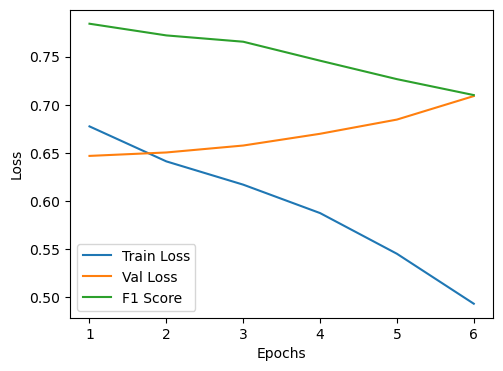




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[219 136]
 [ 40 605]] 

Accuracy: 82.4 

F1 Score: 87.3 

Balanced accuracy: 77.7 

AUC Score: 77.7 


----- TEST -----

Confusion matrix
 [[110 339]
 [181 637]] 

Accuracy: 59.0 

F1 Score: 71.0 

Balanced accuracy: 51.2 

AUC Score: 51.2 

_______________________________________________________________________


In [242]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_bert.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_bert.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_bert, y_train, X_test_embeddings_bert, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_bert_train, accuracy_nn_bert_train, f1_nn_bert_train, balaccuracy_nn_bert_train, rocauc_nn_bert_train = classifier.evaluate(X_train_embeddings_bert, y_train)

print('\n----- TEST -----')
cm_nn_bert_test, accuracy_nn_bert_test, f1_nn_bert_test, balaccuracy_nn_bert_test, rocauc_nn_bert_test = classifier.evaluate(X_test_embeddings_bert, y_test)
print('_______________________________________________________________________')

## GloVe embeddings

### GloVe + KNN

In [243]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_glove_train, accuracy_knn_glove_train, f1_knn_glove_train, balaccuracy_knn_glove_train, rocauc_knn_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_knn_glove_test, accuracy_knn_glove_test, f1_knn_glove_test, balaccuracy_knn_glove_test, rocauc_knn_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.692 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.679 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.664 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.651 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.664 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.706 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.693 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.674 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.671 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.693 to

### GloVe + XGBoost

In [244]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_glove_train, accuracy_xgb_glove_train, f1_xgb_glove_train, balaccuracy_xgb_glove_train, rocauc_xgb_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_xgb_glove_test, accuracy_xgb_glove_test, f1_xgb_glove_test, balaccuracy_xgb_glove_test, rocauc_xgb_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.758 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.766 total time=   0.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.763 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.764 total time=   0.5s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, objective=reg:squarederror, subsample=0.7;, score=0.771 total time=   0.5s
[CV 1/5] END colsample_bytree=0.5

### GloVe + Random Forest

In [245]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25], 
    'max_features': [5, 10],
    'max_depth': [10, 50, None], 
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_glove_train, accuracy_rf_glove_train, f1_rf_glove_train, balaccuracy_rf_glove_train, rocauc_rf_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_rf_glove_test, accuracy_rf_glove_test, f1_rf_glove_test, balaccuracy_rf_glove_test, rocauc_rf_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.681 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.611 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.676 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.634 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=50, max_features=10, n_estimators=10;, score=0.634 total time=   0.0s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=25;, score=0.752 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=25;, score=0.751 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=25;, score=0.769 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=5, n_esti

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


### GloVe + SVC

In [246]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_glove_train, accuracy_svc_glove_train, f1_svc_glove_train, balaccuracy_svc_glove_train, rocauc_svc_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_svc_glove_test, accuracy_svc_glove_test, f1_svc_glove_test, balaccuracy_svc_glove_test, rocauc_svc_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.718 total time=   0.1s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.659 total time=   0.1s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.714 total time=   0.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.738 total time=   0.1s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.689 total time=   0.1s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.765 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.785 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.770 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.787 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.779 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.784 total time=   0.1s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;

### GloVe + Logistic Regression

In [247]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_glove, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_glove, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_glove_train, accuracy_lr_glove_train, f1_lr_glove_train, balaccuracy_lr_glove_train, rocauc_lr_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_lr_glove_test, accuracy_lr_glove_test, f1_lr_glove_test, balaccuracy_lr_glove_test, rocauc_lr_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.84, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.84, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.84, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.84, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.84, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.85, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.85, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.85, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.85, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.85, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.04, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarni

[CV 3/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.784 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.784 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.780 total time=   0.0s
[CV 1/5] END C=0.06, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.06, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.06, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.06, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.06, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END ....C=0.91, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.91, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.91, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.91, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] E

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
65 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_s

### GloVe + Neural Network

Epoch 1/15 | Train Loss: 0.6582 | Val Loss: 0.6523 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 2/15 | Train Loss: 0.6394 | Val Loss: 0.6499 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 3/15 | Train Loss: 0.6228 | Val Loss: 0.6494 | F1 Score: 0.7833 | Balanced Accuracy: 0.4993 | AUC: 0.4993
Epoch 4/15 | Train Loss: 0.6023 | Val Loss: 0.6513 | F1 Score: 0.7751 | Balanced Accuracy: 0.5024 | AUC: 0.5024
Epoch 5/15 | Train Loss: 0.5786 | Val Loss: 0.6556 | F1 Score: 0.7687 | Balanced Accuracy: 0.5128 | AUC: 0.5128
Epoch 6/15 | Train Loss: 0.5496 | Val Loss: 0.6621 | F1 Score: 0.7621 | Balanced Accuracy: 0.5210 | AUC: 0.5210
Epoch 7/15 | Train Loss: 0.5189 | Val Loss: 0.6709 | F1 Score: 0.7572 | Balanced Accuracy: 0.5364 | AUC: 0.5364
Epoch 8/15 | Train Loss: 0.4857 | Val Loss: 0.6813 | F1 Score: 0.7440 | Balanced Accuracy: 0.5316 | AUC: 0.5316
Early stopping triggered. No improvement in 5 epochs.


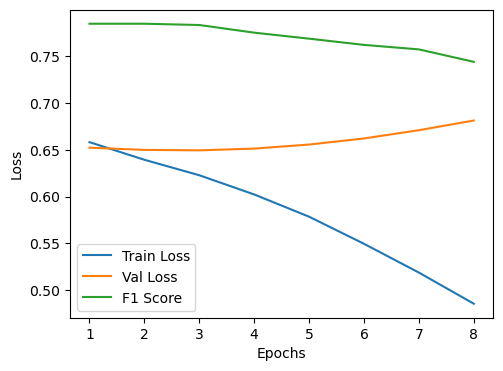




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[205 150]
 [ 19 626]] 

Accuracy: 83.1 

F1 Score: 88.1 

Balanced accuracy: 77.4 

AUC Score: 77.4 


----- TEST -----

Confusion matrix
 [[ 97 352]
 [125 693]] 

Accuracy: 62.4 

F1 Score: 74.4 

Balanced accuracy: 53.2 

AUC Score: 53.2 

_______________________________________________________________________


In [248]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_glove.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_glove.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_glove, y_train, X_test_embeddings_glove, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_glove_train, accuracy_nn_glove_train, f1_nn_glove_train, balaccuracy_nn_glove_train, rocauc_nn_glove_train = classifier.evaluate(X_train_embeddings_glove, y_train)

print('\n----- TEST -----')
cm_nn_glove_test, accuracy_nn_glove_test, f1_nn_glove_test, balaccuracy_nn_glove_test, rocauc_nn_glove_test = classifier.evaluate(X_test_embeddings_glove, y_test)
print('_______________________________________________________________________')

## Word2Vec

### Word2Vec + KNN

In [249]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_w2v_train, accuracy_knn_w2v_train, f1_knn_w2v_train, balaccuracy_knn_w2v_train, rocauc_knn_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_knn_w2v_test, accuracy_knn_w2v_test, f1_knn_w2v_test, balaccuracy_knn_w2v_test, rocauc_knn_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=minkowski, n_neighbors=6, weights=uniform;, score=0.648 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=6, weights=uniform;, score=0.638 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=6, weights=uniform;, score=0.714 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=6, weights=uniform;, score=0.612 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=6, weights=uniform;, score=0.570 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=6, weights=uniform;, score=0.632 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=6, weights=uniform;, score=0.664 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=6, weights=uniform;, score=0.690 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=6, weights=uniform;, score=0.636 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=6, weights=uniform;, score=0.614 total t

### Word2Vec + XGBoost

In [250]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_w2v_train, accuracy_xgb_w2v_train, f1_xgb_w2v_train, balaccuracy_xgb_w2v_train, rocauc_xgb_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_xgb_w2v_test, accuracy_xgb_w2v_test, f1_xgb_w2v_test, balaccuracy_xgb_w2v_test, rocauc_xgb_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.676 total time=   1.4s
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.713 total time=   1.4s
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.698 total time=   1.3s
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.681 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=500, objective=reg:squarederror, subsample=0.5;, score=0.656 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, lea

### Word2Vec + Random Forest

In [251]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_w2v_train, accuracy_rf_w2v_train, f1_rf_w2v_train, balaccuracy_rf_w2v_train, rocauc_rf_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_rf_w2v_test, accuracy_rf_w2v_test, f1_rf_w2v_test, balaccuracy_rf_w2v_test, rocauc_rf_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=10;, score=0.654 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=10;, score=0.669 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=10;, score=0.686 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=10;, score=0.648 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=50, max_features=10, n_estimators=10;, score=0.723 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.741 total time=   0.0s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.745 total time=   0.0s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.751 total time=   0.0s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=5, n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


### Word2Vec + SVC

In [252]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_w2v_train, accuracy_svc_w2v_train, f1_svc_w2v_train, balaccuracy_svc_w2v_train, rocauc_svc_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_svc_w2v_test, accuracy_svc_w2v_test, f1_svc_w2v_test, balaccuracy_svc_w2v_test, rocauc_svc_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.757 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.786 total time=   0.1s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.758 total time=   0.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.742 total time=   0.1s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.748 total time=   0.1s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.768 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.782 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.774 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.765 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.772 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.777 total time=   0.1s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.784 total time=   0.1s
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.780 total time=   0.1s
[CV 4/5] END ......C=1, gamm

### Word2Vec + Logistic Regression

In [253]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_word2vec, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_word2vec, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_w2v_train, accuracy_lr_w2v_train, f1_lr_w2v_train, balaccuracy_lr_w2v_train, rocauc_lr_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_lr_w2v_test, accuracy_lr_w2v_test, f1_lr_w2v_test, balaccuracy_lr_w2v_test, rocauc_lr_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.63, penalty=l2, solver=liblinear;, score=0.741 total time=   0.0s
[CV 2/5] END C=0.63, penalty=l2, solver=liblinear;, score=0.784 total time=   0.0s
[CV 3/5] END C=0.63, penalty=l2, solver=liblinear;, score=0.776 total time=   0.0s
[CV 4/5] END C=0.63, penalty=l2, solver=liblinear;, score=0.759 total time=   0.0s
[CV 5/5] END C=0.63, penalty=l2, solver=liblinear;, score=0.758 total time=   0.0s
[CV 1/5] END C=0.26, penalty=none, solver=lbfgs;, score=0.605 total time=   0.0s
[CV 2/5] END C=0.26, penalty=none, so

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarni

[CV 5/5] END C=0.26, penalty=none, solver=lbfgs;, score=0.606 total time=   0.0s
[CV 1/5] END C=0.35000000000000003, penalty=l2, solver=saga;, score=0.761 total time=   0.1s
[CV 2/5] END C=0.35000000000000003, penalty=l2, solver=saga;, score=0.785 total time=   0.1s
[CV 3/5] END C=0.35000000000000003, penalty=l2, solver=saga;, score=0.779 total time=   0.1s
[CV 4/5] END C=0.35000000000000003, penalty=l2, solver=saga;, score=0.770 total time=   0.1s
[CV 5/5] END C=0.35000000000000003, penalty=l2, solver=saga;, score=0.774 total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END ...C=0.0, penalty=none, solver=sag;, score=0.614 total time=   0.2s
[CV 2/5] END ...C=0.0, penalty=none, solver=sag;, score=0.686 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END ...C=0.0, penalty=none, solver=sag;, score=0.625 total time=   0.2s
[CV 4/5] END ...C=0.0, penalty=none, solver=sag;, score=0.659 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END ...C=0.0, penalty=none, solver=sag;, score=0.606 total time=   0.2s
[CV 1/5] END C=0.8, penalty=none, solver=newton-cg;, score=0.605 total time=   0.0s
[CV 2/5] END C=0.8, penalty=none, solver=newton-cg;, score=0.669 total time=   0.0s
[CV 3/5] END C=0.8, penalty=none, solver=newton-cg;, score=0.610 total time=   0.1s
[CV 4/5] END C=0.8, penalty=none, solver=newton-cg;, score=0.688 total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.8, penalty=none, solver=newton-cg;, score=0.598 total time=   0.0s
[CV 1/5] END C=0.61, penalty=none, solver=lbfgs;, score=0.605 total time=   0.0s
[CV 2/5] END C=0.61, penalty=none, solver=lbfgs;, score=0.664 total time=   0.0s
[CV 3/5] END C=0.61, penalty=none, solver=lbfgs;, score=0.610 total time=   0.0s
[CV 4/5] END C=0.61, penalty=none, solver=lbfgs;, score=0.682 total time=   0.0s
[CV 5/5] END C=0.61, penalty=none, solver=lbfgs;, score=0.606 total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 1/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.740 total time=   0.0s
[CV 2/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.787 total time=   0.0s
[CV 3/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.774 total time=   0.0s
[CV 4/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.759 total time=   0.0s
[CV 5/5] END ....C=0.59, penalty=l2, solver=sag;, score=0.758 total time=   0.0s
[CV 1/5] END C=0.11, penalty=l1, solver=liblinear;, score=0.784 total time=   0.0s
[CV 2/5] END C=0.11, penalty=l1, solver=liblinear;, score=0.784 total time=   0.0s
[CV 3/5] END C=0.11, penalty=l1, solver=liblinear;, score=0.784 total time=   0.0s
[CV 4/5] END C=0.11, penalty=l1, solver=liblinear;, score=0.784 total time=   0.0s
[CV 5/5] END C=0.11, penalty=l1, solver=liblinear;, score=0.784 total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarni

[CV 1/5] END C=0.19, penalty=none, solver=lbfgs;, score=0.605 total time=   0.0s
[CV 2/5] END C=0.19, penalty=none, solver=lbfgs;, score=0.664 total time=   0.0s
[CV 3/5] END C=0.19, penalty=none, solver=lbfgs;, score=0.610 total time=   0.0s
[CV 4/5] END C=0.19, penalty=none, solver=lbfgs;, score=0.682 total time=   0.0s
[CV 5/5] END C=0.19, penalty=none, solver=lbfgs;, score=0.606 total time=   0.0s
[CV 1/5] END C=0.43, penalty=none, solver=newton-cg;, score=0.605 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.43, penalty=none, solver=newton-cg;, score=0.669 total time=   0.1s
[CV 3/5] END C=0.43, penalty=none, solver=newton-cg;, score=0.610 total time=   0.1s
[CV 4/5] END C=0.43, penalty=none, solver=newton-cg;, score=0.688 total time=   0.0s
[CV 5/5] END C=0.43, penalty=none, solver=newton-cg;, score=0.598 total time=   0.0s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=0.6, penalty=l1, solver=saga;, score=0.780 total time=   0.2s
[CV 2/5] END ....C=0.6, penalty=l1, solver=saga;, score=0.784 total time=   0.2s
[CV 3/5] END ....C=0.6, penalty=l1, solver=saga;, score=0.780 total time=   0.2s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=0.6, penalty=l1, solver=saga;, score=0.784 total time=   0.3s
[CV 5/5] END ....C=0.6, penalty=l1, solver=saga;, score=0.780 total time=   0.2s
[CV 1/5] END C=0.23, penalty=l2, solver=liblinear;, score=0.785 total time=   0.0s
[CV 2/5] END C=0.23, penalty=l2, solver=liblinear;, score=0.785 total time=   0.0s
[CV 3/5] END C=0.23, penalty=l2, solver=liblinear;, score=0.783 total time=   0.0s
[CV 4/5] END C=0.23, penalty=l2, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=0.23, penalty=l2, solver=liblinear;, score=0.777 total time=   0.0s
[CV 1/5] END C=0.64, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.64, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.64, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.64, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.64, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ...C=

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.34, penalty=none, solver=newton-cg;, score=0.610 total time=   0.1s
[CV 4/5] END C=0.34, penalty=none, solver=newton-cg;, score=0.688 total time=   0.0s
[CV 5/5] END C=0.34, penalty=none, solver=newton-cg;, score=0.598 total time=   0.0s
[CV 1/5] END ...C=0.25, penalty=l1, solver=saga;, score=0.784 total time=   0.1s
[CV 2/5] END ...C=0.25, penalty=l1, solver=saga;, score=0.784 total time=   0.0s
[CV 3/5] END ...C=0.25, penalty=l1, solver=saga;, score=0.784 total time=   0.0s
[CV 4/5] END ...C=0.25, penalty=l1, solver=saga;, score=0.784 total time=   0.0s
[CV 5/5] END ...C=0.25, penalty=l1, solver=saga;, score=0.784 total time=   0.0s
[CV 1/5] END C=0.35000000000000003, penalty=l2, solver=lbfgs;, score=0.761 total time=   0.0s
[CV 2/5] END C=0.35000000000000003, penalty=l2, solver=lbfgs;, score=0.785 total time=   0.0s
[CV 3/5] END C=0.35000000000000003, penalty=l2, solver=lbfgs;, score=0.779 total time=   0.0s
[CV 4/5] END C=0.35000000000000003, penalty=l2, solver=lbf

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_

### Word2Vec + Neural Network

Epoch 1/15 | Train Loss: 0.6557 | Val Loss: 0.6495 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 2/15 | Train Loss: 0.6402 | Val Loss: 0.6499 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 3/15 | Train Loss: 0.6277 | Val Loss: 0.6518 | F1 Score: 0.7839 | Balanced Accuracy: 0.4999 | AUC: 0.4999
Epoch 4/15 | Train Loss: 0.6129 | Val Loss: 0.6555 | F1 Score: 0.7819 | Balanced Accuracy: 0.5007 | AUC: 0.5007
Epoch 5/15 | Train Loss: 0.5940 | Val Loss: 0.6617 | F1 Score: 0.7792 | Balanced Accuracy: 0.5088 | AUC: 0.5088
Epoch 6/15 | Train Loss: 0.5737 | Val Loss: 0.6694 | F1 Score: 0.7732 | Balanced Accuracy: 0.5107 | AUC: 0.5107
Early stopping triggered. No improvement in 5 epochs.


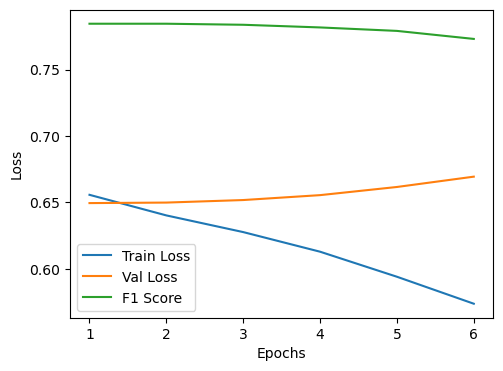




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[ 78 277]
 [  6 639]] 

Accuracy: 71.7 

F1 Score: 81.9 

Balanced accuracy: 60.5 

AUC Score: 60.5 


----- TEST -----

Confusion matrix
 [[ 31 418]
 [ 39 779]] 

Accuracy: 63.9 

F1 Score: 77.3 

Balanced accuracy: 51.1 

AUC Score: 51.1 

_______________________________________________________________________


In [254]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_word2vec.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_word2vec.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_word2vec, y_train, X_test_embeddings_word2vec, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_w2v_train, accuracy_nn_w2v_train, f1_nn_w2v_train, balaccuracy_nn_w2v_train, rocauc_nn_w2v_train = classifier.evaluate(X_train_embeddings_word2vec, y_train)

print('\n----- TEST -----')
cm_nn_w2v_test, accuracy_nn_w2v_test, f1_nn_w2v_test, balaccuracy_nn_w2v_test, rocauc_nn_w2v_test = classifier.evaluate(X_test_embeddings_word2vec, y_test)
print('_______________________________________________________________________')

## GPT2

### GPT2 + KNN

In [255]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_gpt2_train, accuracy_knn_gpt2_train, f1_knn_gpt2_train, balaccuracy_knn_gpt2_train, rocauc_knn_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_knn_gpt2_test, accuracy_knn_gpt2_test, f1_knn_gpt2_test, balaccuracy_knn_gpt2_test, rocauc_knn_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.693 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.688 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.699 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.705 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.683 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.552 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.550 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.653 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.672 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.582 to

### GPT2 + XGBoost

In [256]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_gpt2_train, accuracy_xgb_gpt2_train, f1_xgb_gpt2_train, balaccuracy_xgb_gpt2_train, rocauc_xgb_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_xgb_gpt2_test, accuracy_xgb_gpt2_test, f1_xgb_gpt2_test, balaccuracy_xgb_gpt2_test, rocauc_xgb_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.712 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.682 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.695 total time=   1.1s
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.669 total time=   1.1s
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.696 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, lea

### GPT2 + Random Forest

In [257]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_gpt2_train, accuracy_rf_gpt2_train, f1_rf_gpt2_train, balaccuracy_rf_gpt2_train, rocauc_rf_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_rf_gpt2_test, accuracy_rf_gpt2_test, f1_rf_gpt2_test, balaccuracy_rf_gpt2_test, rocauc_rf_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, max_depth=None, max_features=10, n_estimators=10;, score=0.674 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=10, n_estimators=10;, score=0.620 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=None, max_features=10, n_estimators=10;, score=0.677 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=None, max_features=10, n_estimators=10;, score=0.705 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=None, max_features=10, n_estimators=10;, score=0.708 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.734 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.701 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=10, n_estimators=10;, score=0.724 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


### GPT2 + SVC

In [258]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_gpt2_train, accuracy_svc_gpt2_train, f1_svc_gpt2_train, balaccuracy_svc_gpt2_train, rocauc_svc_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_svc_gpt2_test, accuracy_svc_gpt2_test, f1_svc_gpt2_test, balaccuracy_svc_gpt2_test, rocauc_svc_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.769 total time=   0.1s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.783 total time=   0.1s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.784 total time=   0.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.784 total time=   0.1s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.777 total time=   0.1s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.777 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.784 total time=   0.2s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.784 total time=   0.2s
[CV 3/5] END ......C=1, gamm

### GPT2 + Logistic Regression

In [259]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_gpt2, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_gpt2, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_gpt2_train, accuracy_lr_gpt2_train, f1_lr_gpt2_train, balaccuracy_lr_gpt2_train, rocauc_lr_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_lr_gpt2_test, accuracy_lr_gpt2_test, f1_lr_gpt2_test, balaccuracy_lr_gpt2_test, rocauc_lr_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ....C=0.46, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.46, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.46, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.46, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.46, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.9400000000000001, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.9400000000000001, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.9400000000000001, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.9400000000000001, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.9400000000000001, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ....C

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_s

### GPT2 + Neural Network

Epoch 1/15 | Train Loss: 0.6549 | Val Loss: 0.6492 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 2/15 | Train Loss: 0.6445 | Val Loss: 0.6491 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 3/15 | Train Loss: 0.6327 | Val Loss: 0.6500 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 4/15 | Train Loss: 0.6145 | Val Loss: 0.6528 | F1 Score: 0.7753 | Balanced Accuracy: 0.4961 | AUC: 0.4961
Epoch 5/15 | Train Loss: 0.5894 | Val Loss: 0.6592 | F1 Score: 0.7587 | Balanced Accuracy: 0.4992 | AUC: 0.4992
Epoch 6/15 | Train Loss: 0.5579 | Val Loss: 0.6705 | F1 Score: 0.7499 | Balanced Accuracy: 0.5168 | AUC: 0.5168
Epoch 7/15 | Train Loss: 0.5275 | Val Loss: 0.6864 | F1 Score: 0.7406 | Balanced Accuracy: 0.5157 | AUC: 0.5157
Early stopping triggered. No improvement in 5 epochs.


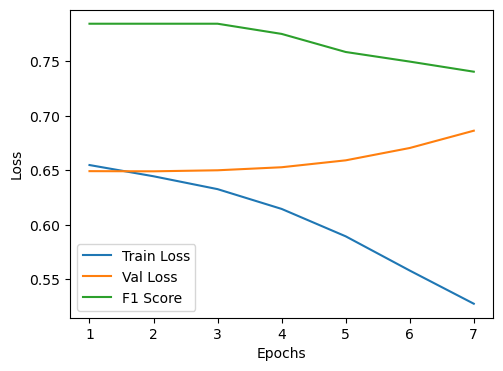




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[179 176]
 [ 32 613]] 

Accuracy: 79.2 

F1 Score: 85.5 

Balanced accuracy: 72.7 

AUC Score: 72.7 


----- TEST -----

Confusion matrix
 [[ 80 369]
 [120 698]] 

Accuracy: 61.4 

F1 Score: 74.1 

Balanced accuracy: 51.6 

AUC Score: 51.6 

_______________________________________________________________________


In [260]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_gpt2.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_gpt2.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_gpt2, y_train, X_test_embeddings_gpt2, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_gpt2_train, accuracy_nn_gpt2_train, f1_nn_gpt2_train, balaccuracy_nn_gpt2_train, rocauc_nn_gpt2_train = classifier.evaluate(X_train_embeddings_gpt2, y_train)

print('\n----- TEST -----')
cm_nn_gpt2_test, accuracy_nn_gpt2_test, f1_nn_gpt2_test, balaccuracy_nn_gpt2_test, rocauc_nn_gpt2_test = classifier.evaluate(X_test_embeddings_gpt2, y_test)
print('_______________________________________________________________________')

## RoBERTa

### RoBERTa + KNN

In [261]:
# Instantiate classifier
classifier = KNNClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_knn_roberta_train, accuracy_knn_roberta_train, f1_knn_roberta_train, balaccuracy_knn_roberta_train, rocauc_knn_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_knn_roberta_test, accuracy_knn_roberta_test, f1_knn_roberta_test, balaccuracy_knn_roberta_test, rocauc_knn_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.621 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.630 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.613 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.567 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=2, weights=distance;, score=0.601 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.659 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.688 total time=   0.1s
[CV 3/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.698 total time=   0.1s
[CV 4/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.599 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.6

### RoBERTa + XGBoost

In [262]:
# Instantiate classifier
classifier = XGBoostClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_xgb_roberta_train, accuracy_xgb_roberta_train, f1_xgb_roberta_train, balaccuracy_xgb_roberta_train, rocauc_xgb_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_xgb_roberta_test, accuracy_xgb_roberta_test, f1_xgb_roberta_test, balaccuracy_xgb_roberta_test, rocauc_xgb_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.644 total time=   1.3s
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.638 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.614 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.619 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, min_child_weight=5, n_estimators=500, objective=reg:squarederror, subsample=0.7;, score=0.715 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, lea

### RoBERTa + Random Forest

In [263]:
# Instantiate classifier
classifier = RFClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'n_estimators': [10, 25],
    'max_features': [5, 10],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False]
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_rf_roberta_train, accuracy_rf_roberta_train, f1_rf_roberta_train, balaccuracy_rf_roberta_train, rocauc_rf_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_rf_roberta_test, accuracy_rf_roberta_test, f1_rf_roberta_test, balaccuracy_rf_roberta_test, rocauc_rf_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=25;, score=0.772 total time=   0.1s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=25;, score=0.757 total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=25;, score=0.779 total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=25;, score=0.766 total time=   0.1s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=25;, score=0.777 total time=   0.1s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.735 total time=   0.0s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.712 total time=   0.0s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=5, n_estimators=10;, score=0.719 total time=   0.0s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=5, n_esti

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


### RoBERTa + SVC

In [264]:
# Instantiate classifier
classifier = SVClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale']
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_svc_roberta_train, accuracy_svc_roberta_train, f1_svc_roberta_train, balaccuracy_svc_roberta_train, rocauc_svc_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_svc_roberta_test, accuracy_svc_roberta_test, f1_svc_roberta_test, balaccuracy_svc_roberta_test, rocauc_svc_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.784 total time=   0.1s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.780 total time=   0.1s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.784 total time=   0.1s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.784 total time=   0.1s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.784 total time=   0.1s
[CV 1/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 2/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 3/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 4/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 5/5] END .....C=1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.784 total time=   0.2s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.784 total time=   0.2s
[CV 3/5] END ......C=1, gamm

### RoBERTa + Logistic Regression

In [265]:
# Instantiate classifier
classifier = LRClassifier()

# Perform randomized search over hyperparameters
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : np.arange(0, 1, 0.01)
}
classifier.randomized_search(X_train_embeddings_roberta, y_train, param_distributions)

# Train classifier on training data
classifier.fit(X_train_embeddings_roberta, y_train)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_lr_roberta_train, accuracy_lr_roberta_train, f1_lr_roberta_train, balaccuracy_lr_roberta_train, rocauc_lr_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_lr_roberta_test, accuracy_lr_roberta_test, f1_lr_roberta_test, balaccuracy_lr_roberta_test, rocauc_lr_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=0.84, penalty=l2, solver=sag;, score=0.779 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=0.84, penalty=l2, solver=sag;, score=0.773 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=0.84, penalty=l2, solver=sag;, score=0.779 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=0.84, penalty=l2, solver=sag;, score=0.784 total time=   0.4s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Se

[CV 5/5] END ....C=0.84, penalty=l2, solver=sag;, score=0.787 total time=   0.4s
[CV 1/5] END C=0.7000000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.7000000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.7000000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.7000000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.7000000000000001, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.15, penalty=none, solver=lbfgs;, score=0.590 total time=   0.1s
[CV 2/5] END C=0.15, penalty=none, solver=lbfgs;, score=0.638 total time=   0.1s
[CV 3/5] END C=0.15, penalty=none, solver=lbfgs;, score=0.687 total time=   0.1s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

[CV 4/5] END C=0.15, penalty=none, solver=lbfgs;, score=0.623 total time=   0.1s
[CV 5/5] END C=0.15, penalty=none, solver=lbfgs;, score=0.715 total time=   0.1s
[CV 1/5] END C=0.49, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.0s
[CV 2/5] END C=0.49, penalty=l2, solver=newton-cg;, score=0.773 total time=   0.0s
[CV 3/5] END C=0.49, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.1s
[CV 4/5] END C=0.49, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.1s
[CV 5/5] END C=0.49, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.0s
[CV 1/5] END C=0.04, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.04, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.04, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.04, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.04, penalty=elasticnet, solver=newton-cg;, score=n

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END .C=0.66, penalty=none, solver=saga;, score=0.765 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END .C=0.66, penalty=none, solver=saga;, score=0.748 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END .C=0.66, penalty=none, solver=saga;, score=0.763 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END .C=0.66, penalty=none, solver=saga;, score=0.758 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .C=0.66, penalty=none, solver=saga;, score=0.772 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=0.46, penalty=l2, solver=saga;, score=0.784 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=0.46, penalty=l2, solver=saga;, score=0.773 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.46, penalty=l2, solver=saga;, score=0.784 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=0.46, penalty=l2, solver=saga;, score=0.784 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...C=0.46, penalty=l2, solver=saga;, score=0.784 total time=   0.5s
[CV 1/5] END ..C=0.18, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 2/5] END ..C=0.18, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.1s
[CV 3/5] END ..C=0.18, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 4/5] END ..C=0.18, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 5/5] END ..C=0.18, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 1/5] END ..C=0.23, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 2/5] END ..C=0.23, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 3/5] END ..C=0.23, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 4/5] END ..C=0.23, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 5/5] END ..C=0.23, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 1/5] END C=0.35000000000000003, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.35

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.6900000000000001, penalty=l2, solver=saga;, score=0.784 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.6900000000000001, penalty=l2, solver=saga;, score=0.773 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.6900000000000001, penalty=l2, solver=saga;, score=0.787 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.6900000000000001, penalty=l2, solver=saga;, score=0.784 total time=   0.5s


/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.6900000000000001, penalty=l2, solver=saga;, score=0.784 total time=   0.5s
[CV 1/5] END C=0.2, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.1s
[CV 2/5] END C=0.2, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.1s
[CV 3/5] END C=0.2, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.1s
[CV 4/5] END C=0.2, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.1s
[CV 5/5] END C=0.2, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.0s
[CV 1/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.43, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5

/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/szymon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_

### RoBERTa + Neural Network

Epoch 1/15 | Train Loss: 0.6565 | Val Loss: 0.6509 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 2/15 | Train Loss: 0.6514 | Val Loss: 0.6511 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 3/15 | Train Loss: 0.6496 | Val Loss: 0.6509 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 4/15 | Train Loss: 0.6458 | Val Loss: 0.6508 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 5/15 | Train Loss: 0.6416 | Val Loss: 0.6509 | F1 Score: 0.7847 | Balanced Accuracy: 0.5000 | AUC: 0.5000
Epoch 6/15 | Train Loss: 0.6377 | Val Loss: 0.6517 | F1 Score: 0.7841 | Balanced Accuracy: 0.4994 | AUC: 0.4994
Epoch 7/15 | Train Loss: 0.6340 | Val Loss: 0.6529 | F1 Score: 0.7795 | Balanced Accuracy: 0.4961 | AUC: 0.4961
Epoch 8/15 | Train Loss: 0.6295 | Val Loss: 0.6543 | F1 Score: 0.7773 | Balanced Accuracy: 0.4974 | AUC: 0.4974
Epoch 9/15 | Train Loss: 0.6244 | Val Loss: 0.6569 | F1 Score: 0.7719 | Balanced Accuracy: 0.4999 | AUC:

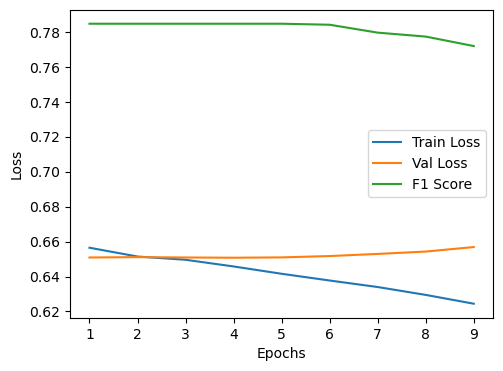




_______________________________________________________________________
EVALUATION

----- TRAIN -----

Confusion matrix
 [[ 41 314]
 [ 16 629]] 

Accuracy: 67.0 

F1 Score: 79.2 

Balanced accuracy: 54.5 

AUC Score: 54.5 


----- TEST -----

Confusion matrix
 [[ 18 431]
 [ 33 785]] 

Accuracy: 63.4 

F1 Score: 77.2 

Balanced accuracy: 50.0 

AUC Score: 50.0 

_______________________________________________________________________


In [266]:
# --------------------
# SET PARAMETERS
dropout_rate = 0.1
epochs_number = 15
learning_rate = 0.0001
early_stopping = 5
# --------------------

input_dim = X_train_embeddings_roberta.shape[1]  # Dimensionality of word embeddings
hidden_dim = X_train_embeddings_roberta.shape[1]*2  # Number of units in the hidden layer

classifier = NeuralNetworkClassifier(input_dim, hidden_dim, dropout=dropout_rate)

# Fit the model
classifier.fit(X_train_embeddings_roberta, y_train, X_test_embeddings_roberta, y_test, num_epochs=epochs_number, lr=learning_rate, patience=early_stopping)

# Evaluate classifier
print('\n')
print('\n_______________________________________________________________________')
print('EVALUATION')

print('\n----- TRAIN -----')
cm_nn_roberta_train, accuracy_nn_roberta_train, f1_nn_roberta_train, balaccuracy_nn_roberta_train, rocauc_nn_roberta_train = classifier.evaluate(X_train_embeddings_roberta, y_train)

print('\n----- TEST -----')
cm_nn_roberta_test, accuracy_nn_roberta_test, f1_nn_roberta_test, balaccuracy_nn_roberta_test, rocauc_nn_roberta_test = classifier.evaluate(X_test_embeddings_roberta, y_test)
print('_______________________________________________________________________')

# Results

In [267]:
#create data
data = [["LR+GloVe", accuracy_lr_glove_test, f1_lr_glove_test, balaccuracy_lr_glove_test, rocauc_lr_glove_test],
        ["KNN+GloVe", accuracy_knn_glove_test, f1_knn_glove_test, balaccuracy_knn_glove_test, rocauc_knn_glove_test],
        ["SVC+GloVe", accuracy_svc_glove_test, f1_svc_glove_test, balaccuracy_svc_glove_test, rocauc_svc_glove_test],
        ["RandomForest+GloVe", accuracy_rf_glove_test, f1_rf_glove_test, balaccuracy_rf_glove_test, rocauc_rf_glove_test],
        ["XGBoost+GloVe", accuracy_xgb_glove_test, f1_xgb_glove_test, balaccuracy_xgb_glove_test, rocauc_xgb_glove_test],
        ["NeuralNetwork+GloVe", accuracy_nn_glove_test, f1_nn_glove_test, balaccuracy_nn_glove_test, rocauc_nn_glove_test],
        ["LR+Word2Vec", accuracy_lr_w2v_test, f1_lr_w2v_test, balaccuracy_lr_w2v_test, rocauc_lr_w2v_test],
        ["KNN+Word2Vec", accuracy_knn_w2v_test, f1_knn_w2v_test, balaccuracy_knn_w2v_test, rocauc_knn_w2v_test],
        ["SVC+Word2Vec", accuracy_svc_w2v_test, f1_svc_w2v_test, balaccuracy_svc_w2v_test, rocauc_svc_w2v_test],
        ["RandomForest + Word2Vec", accuracy_rf_w2v_test, f1_rf_w2v_test, balaccuracy_rf_w2v_test, rocauc_rf_w2v_test],
        ["XGBoost+Word2Vec", accuracy_xgb_w2v_test, f1_xgb_w2v_test, balaccuracy_xgb_w2v_test, rocauc_xgb_w2v_test],
        ["NeuralNetwork+Word2Vec", accuracy_nn_w2v_test, f1_nn_w2v_test, balaccuracy_nn_w2v_test, rocauc_nn_w2v_test],
        ["LR+BERT", accuracy_lr_bert_test, f1_lr_bert_test, balaccuracy_lr_bert_test, rocauc_lr_bert_test],
        ["KNN+BERT", accuracy_knn_bert_test, f1_knn_bert_test, balaccuracy_knn_bert_test, rocauc_knn_bert_test],
        ["SVC+BERT", accuracy_svc_bert_test, f1_svc_bert_test, balaccuracy_svc_bert_test, rocauc_svc_bert_test],
        ["RandomForest+BERT", accuracy_rf_bert_test, f1_rf_bert_test, balaccuracy_rf_bert_test, rocauc_rf_bert_test],
        ["XGBoost+BERT", accuracy_xgb_bert_test, f1_xgb_bert_test, balaccuracy_xgb_bert_test, rocauc_xgb_bert_test],
        ["NeuralNetwork+BERT", accuracy_nn_bert_test, f1_nn_bert_test, balaccuracy_nn_bert_test, rocauc_nn_bert_test],
        ["LR+RoBERTa", accuracy_lr_roberta_test, f1_lr_roberta_test, balaccuracy_lr_roberta_test, rocauc_lr_roberta_test],
        ["KNN+RoBERTa", accuracy_knn_roberta_test, f1_knn_roberta_test, balaccuracy_knn_roberta_test, rocauc_knn_roberta_test],
        ["SVC+RoBERTa", accuracy_svc_roberta_test, f1_svc_roberta_test, balaccuracy_svc_roberta_test, rocauc_svc_roberta_test],
        ["RandomForest+RoBERTa", accuracy_rf_roberta_test, f1_rf_roberta_test, balaccuracy_rf_roberta_test, rocauc_rf_roberta_test],
        ["XGBoost+RoBERTa", accuracy_xgb_roberta_test, f1_xgb_roberta_test, balaccuracy_xgb_roberta_test, rocauc_xgb_roberta_test],
        ["NeuralNetwork+RoBERTa", accuracy_nn_roberta_test, f1_nn_roberta_test, balaccuracy_nn_roberta_test, rocauc_nn_roberta_test],
        ["LR+GPT2", accuracy_lr_gpt2_test, f1_lr_gpt2_test, balaccuracy_lr_gpt2_test, rocauc_lr_gpt2_test],
        ["KNN+GPT2", accuracy_knn_gpt2_test, f1_knn_gpt2_test, balaccuracy_knn_gpt2_test, rocauc_knn_gpt2_test],
        ["SVC+GPT2", accuracy_svc_gpt2_test, f1_svc_gpt2_test, balaccuracy_svc_gpt2_test, rocauc_svc_gpt2_test],
        ["RandomForest+GPT2", accuracy_rf_gpt2_test, f1_rf_gpt2_test, balaccuracy_rf_gpt2_test, rocauc_rf_gpt2_test],
        ["XGBoost+GPT2", accuracy_xgb_gpt2_test, f1_xgb_gpt2_test, balaccuracy_xgb_gpt2_test, rocauc_xgb_gpt2_test],
        ["NeuralNetwork+GPT2", accuracy_nn_gpt2_test, f1_nn_gpt2_test, balaccuracy_nn_gpt2_test, rocauc_nn_gpt2_test]]
  
#define header names
col_names = ["Model", "Accuracy", "F1-Score", "Balanced Accuracy", "ROC AUC"]

#save results to csv
if fast:
    with open("results_fast_"+time.strftime("%Y%m%d-%H%M%S")+".csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(col_names)
        for row in data:
            writer.writerow(row)
else:
    with open("results_"+time.strftime("%Y%m%d-%H%M%S")+".csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(col_names)
        for row in data:
            writer.writerow(row)

#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════════╤════════════╤════════════╤═════════════════════╤═══════════╕
│ Model                   │   Accuracy │   F1-Score │   Balanced Accuracy │   ROC AUC │
╞═════════════════════════╪════════════╪════════════╪═════════════════════╪═══════════╡
│ LR+GloVe                │       64.6 │       78.5 │                50   │      50   │
├─────────────────────────┼────────────┼────────────┼─────────────────────┼───────────┤
│ KNN+GloVe               │       60.8 │       73.8 │                50.6 │      50.6 │
├─────────────────────────┼────────────┼────────────┼─────────────────────┼───────────┤
│ SVC+GloVe               │       64.6 │       78.5 │                50   │      50   │
├─────────────────────────┼────────────┼────────────┼─────────────────────┼───────────┤
│ RandomForest+GloVe      │       61.7 │       75.9 │                48.8 │      48.8 │
├─────────────────────────┼────────────┼────────────┼─────────────────────┼───────────┤
│ XGBoost+GloVe           │     

In [268]:
#print(tabulate(data, headers=col_names, tablefmt="latex"))

\begin{tabular}{lrrrr}
\hline
 Model                   &   Accuracy &   F1-Score &   Balanced Accuracy &   ROC AUC \\
\hline
 LR+GloVe                &       64.6 &       78.5 &                50   &      50   \\
 KNN+GloVe               &       60.8 &       73.8 &                50.6 &      50.6 \\
 SVC+GloVe               &       64.6 &       78.5 &                50   &      50   \\
 RandomForest+GloVe      &       61.7 &       75.9 &                48.8 &      48.8 \\
 XGBoost+GloVe           &       63.4 &       77.1 &                50.3 &      50.3 \\
 NeuralNetwork+GloVe     &       62.4 &       74.4 &                53.2 &      53.2 \\
 LR+Word2Vec             &       64.6 &       78.5 &                50   &      50   \\
 KNN+Word2Vec            &       60.7 &       73.8 &                50.4 &      50.4 \\
 SVC+Word2Vec            &       64   &       77.9 &                49.9 &      49.9 \\
 RandomForest + Word2Vec &       61.5 &       74.6 &                50.7 &      50.

In [110]:
# #create data
# lr_results = [
#     ["GloVe", accuracy_lr_glove_test, f1_lr_glove_test],
#     ["Word2Vec", accuracy_lr_w2v_test, f1_lr_w2v_test],
#     ["BERT", accuracy_lr_bert_test, f1_lr_bert_test],
#     ["RoBERTa", accuracy_lr_roberta_test, f1_lr_roberta_test],
#     ["GPT2", accuracy_lr_gpt2_test, f1_lr_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("Logistic Regression")
# # print(tabulate(lr_results, headers=col_names, tablefmt="fancy_grid"))

Logistic Regression
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53.4 │       33.2 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       59   │       40.7 │
├──────────┼────────────┼────────────┤
│ BERT     │       52.8 │       34.6 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       51.9 │       38   │
├──────────┼────────────┼────────────┤
│ GPT2     │       55.2 │       37.6 │
╘══════════╧════════════╧════════════╛


In [111]:
# #create data
# knn_results = [
#     ["GloVe", accuracy_knn_glove_test, f1_knn_glove_test],
#     ["Word2Vec", accuracy_knn_w2v_test, f1_knn_w2v_test],
#     ["BERT", accuracy_knn_bert_test, f1_knn_bert_test],
#     ["RoBERTa", accuracy_knn_roberta_test, f1_knn_roberta_test],
#     ["GPT2", accuracy_knn_gpt2_test, f1_knn_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("KNN")
# print(tabulate(knn_results, headers=col_names, tablefmt="fancy_grid"))

KNN
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53.7 │       34.7 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       55.5 │       40   │
├──────────┼────────────┼────────────┤
│ BERT     │       53.1 │       35.7 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       52.8 │       38.2 │
├──────────┼────────────┼────────────┤
│ GPT2     │       48.5 │       46.6 │
╘══════════╧════════════╧════════════╛


In [112]:
# #create data
# svc_results = [
#     ["GloVe", accuracy_svc_glove_test, f1_svc_glove_test],
#     ["Word2Vec", accuracy_svc_w2v_test, f1_svc_w2v_test],
#     ["BERT", accuracy_svc_bert_test, f1_svc_bert_test],
#     ["RoBERTa", accuracy_svc_roberta_test, f1_svc_roberta_test],
#     ["GPT2", accuracy_svc_gpt2_test, f1_svc_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("SVM Classifier")
# print(tabulate(svc_results, headers=col_names, tablefmt="fancy_grid"))

SVM Classifier
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       56.1 │       34.4 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       59.3 │       39.2 │
├──────────┼────────────┼────────────┤
│ BERT     │       50.4 │       33   │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       52.9 │       36   │
├──────────┼────────────┼────────────┤
│ GPT2     │       55.6 │       35.7 │
╘══════════╧════════════╧════════════╛


In [113]:
# #create data
# rf_results = [
#     ["GloVe", accuracy_rf_glove_test, f1_rf_glove_test],
#     ["Word2Vec", accuracy_rf_w2v_test, f1_rf_w2v_test],
#     ["BERT", accuracy_rf_bert_test, f1_rf_bert_test],
#     ["RoBERTa", accuracy_rf_roberta_test, f1_rf_roberta_test],
#     ["GPT2", accuracy_rf_gpt2_test, f1_rf_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("Random Forest")
# print(tabulate(rf_results, headers=col_names, tablefmt="fancy_grid"))

Random Forest
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       61.2 │       22.9 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       62.9 │       29.9 │
├──────────┼────────────┼────────────┤
│ BERT     │       57.9 │       22.4 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       61.4 │       19.7 │
├──────────┼────────────┼────────────┤
│ GPT2     │       58.2 │       17.2 │
╘══════════╧════════════╧════════════╛


In [114]:
# #create data
# xgb_results = [
#     ["GloVe", accuracy_xgb_glove_test, f1_xgb_glove_test],
#     ["Word2Vec", accuracy_xgb_w2v_test, f1_xgb_w2v_test],
#     ["BERT", accuracy_xgb_bert_test, f1_xgb_bert_test],
#     ["RoBERTa", accuracy_xgb_roberta_test, f1_xgb_roberta_test],
#     ["GPT2", accuracy_xgb_gpt2_test, f1_xgb_gpt2_test]
# ]
#
# #define header names
# col_names = ["Model", "Accuracy", "F1-Score"]
#
# #display table
# print("XGBoost")
# print(tabulate(xgb_results, headers=col_names, tablefmt="fancy_grid"))

XGBoost
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       53   │       36.4 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       56.3 │       38.2 │
├──────────┼────────────┼────────────┤
│ BERT     │       52.3 │       34.8 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       53.9 │       36.2 │
├──────────┼────────────┼────────────┤
│ GPT2     │       52.6 │       35.9 │
╘══════════╧════════════╧════════════╛


In [115]:
#create data
nn_results = [
    ["GloVe", accuracy_nn_glove_test, f1_nn_glove_test],
    ["Word2Vec", accuracy_nn_w2v_test, f1_nn_w2v_test],
    ["BERT", accuracy_nn_bert_test, f1_nn_bert_test],
    ["RoBERTa", accuracy_nn_roberta_test, f1_nn_roberta_test],
    ["GPT2", accuracy_nn_gpt2_test, f1_nn_gpt2_test]
]

#define header names
col_names = ["Model", "Accuracy", "F1-Score"]

#display table
print("NeuralNetwork")
print(tabulate(nn_results, headers=col_names, tablefmt="fancy_grid"))

NeuralNetwork
╒══════════╤════════════╤════════════╕
│ Model    │   Accuracy │   F1-Score │
╞══════════╪════════════╪════════════╡
│ GloVe    │       52.5 │       37.8 │
├──────────┼────────────┼────────────┤
│ Word2Vec │       60.1 │       40   │
├──────────┼────────────┼────────────┤
│ BERT     │       59.6 │       17.9 │
├──────────┼────────────┼────────────┤
│ RoBERTa  │       62.5 │        9.5 │
├──────────┼────────────┼────────────┤
│ GPT2     │       56.4 │       29   │
╘══════════╧════════════╧════════════╛


---